In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# import the dataset
import os
import zipfile
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define paths
ZIP_PATH = "/content/drive/My Drive/dataset.zip"
EXTRACT_PATH = "/content/dataset/dataset"  # Adjusted path

# Step 3: Extract ZIP file if not already extracted
if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall("/content/dataset")  # Extract here

# Step 4: Define dataset directories
train_dir = os.path.join(EXTRACT_PATH, "train")
val_dir = os.path.join(EXTRACT_PATH, "val")

if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError("Dataset directories not found! Check your dataset structure.")

# Step 5: Image Data Generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

Mounted at /content/drive


In [3]:
# Load Training Data
IMG_SIZE = (180, 180)  # Using your original size
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class names
print(f"Class labels: {train_ds.class_indices}")


Found 6231 images belonging to 9 classes.
Found 1664 images belonging to 9 classes.
Class labels: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Exanthems and Drug Eruptions': 3, 'Hair Loss Photos Alopecia and other Hair Diseases': 4, 'Herpes HPV and other STDs Photos': 5, 'Nail Fungus and other Nail Disease': 6, 'Poison Ivy Photos and other Contact Dermatitis': 7, 'Psoriasis pictures Lichen Planus and related diseases': 8}


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

# Constants
IMG_HEIGHT = 180
IMG_WIDTH = 180
NUM_CLASSES = 9


# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Model Architecture
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,

    # Conv Block 1
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Conv Block 2
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Conv Block 3
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# Show model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 247808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   126,878,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,497,417 (490.18 MB)

 Trainable params: 128,494,089 (490.17 MB)

 Non-trainable params: 3,328 (13.00 KB)

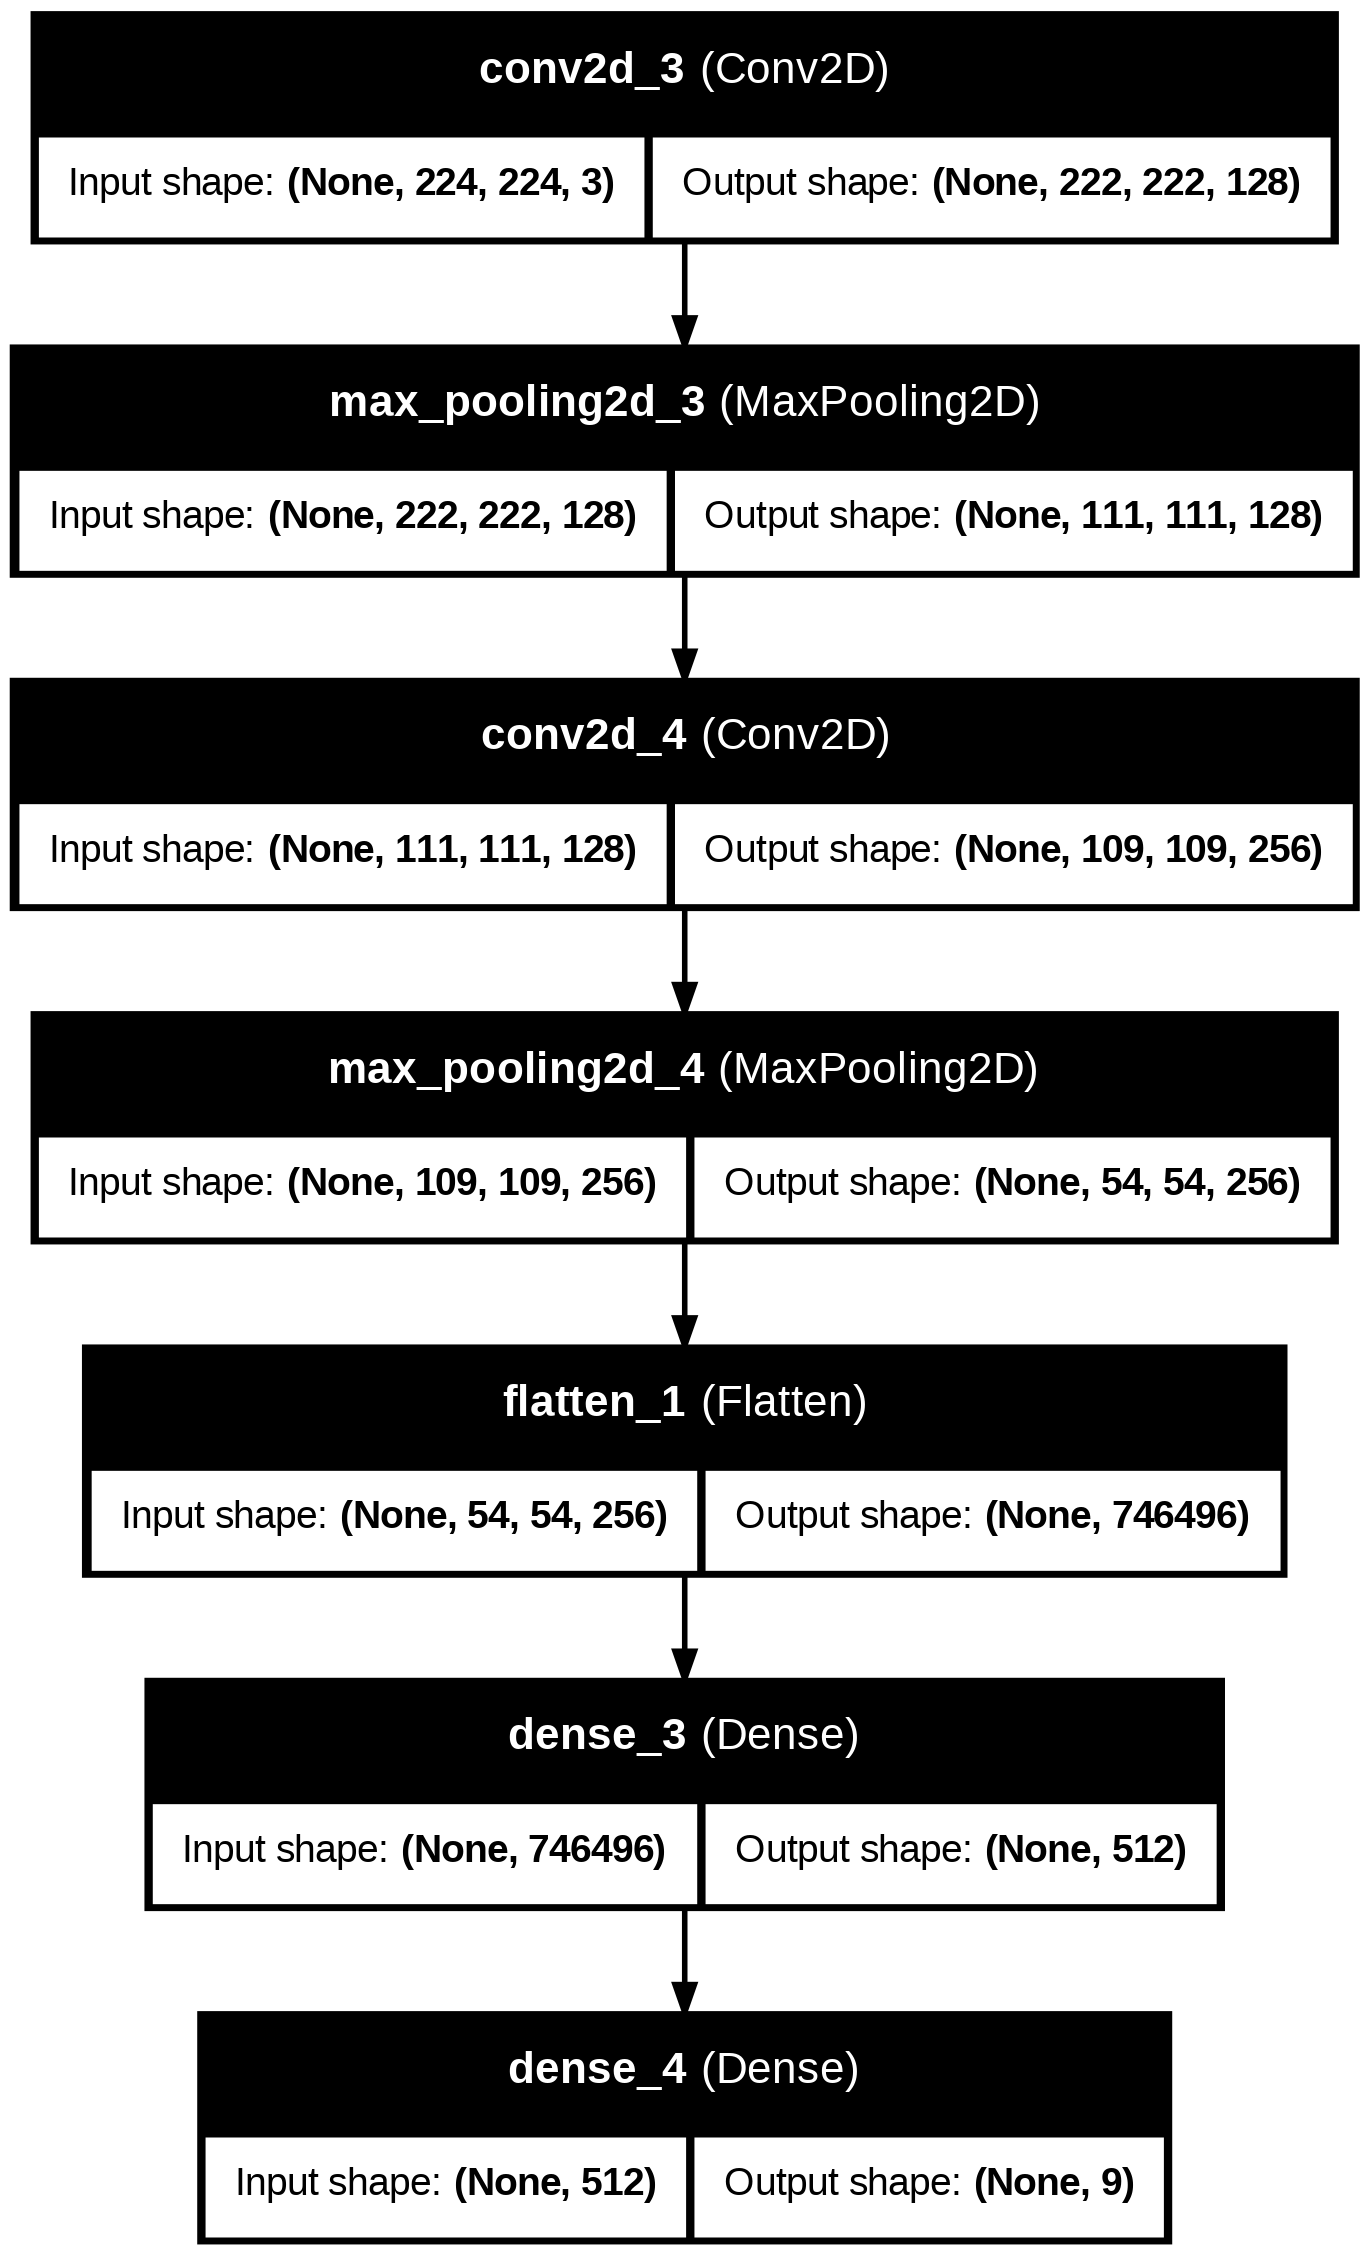

In [7]:
# tf.keras.utils.plot_model(
#     model,
#     to_file ='model_plot.png',
#     show_shapes =True,
#     show_layer_names =True
# )
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Create a simplified model representation
model_simple = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Plot the simplified model
plot_model(
    model_simple,
    to_file='model_simple.png',
    show_shapes=True,
    show_layer_names=True
)

In [8]:
# Define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - accuracy: 0.2286 - loss: 2.4227 - val_accuracy: 0.1731 - val_loss: 4.3908
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.2977 - loss: 1.9578 - val_accuracy: 0.0613 - val_loss: 3.9261
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 519ms/step - accuracy: 0.3481 - loss: 1.8418 - val_accuracy: 0.1953 - val_loss: 2.5695
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 497ms/step - accuracy: 0.3631 - loss: 1.7606 - val_accuracy: 0.2939 - val_loss: 2.0464
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 501ms/step - accuracy: 0.3695 - loss: 1.7538 - val_accuracy: 0.2794 - val_loss: 1.9746
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 499ms/step - accuracy: 0.3846 - loss: 1.7303 - val_accuracy: 0.3113 - val_loss: 2.0190
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.3931 - loss: 1.6959 - val_accuracy: 0.2945 - val_loss: 2.3133
Epoch 8/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 146s 520ms/step - accuracy: 0.3961 - loss

In [9]:
# Evaluate the model
loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print(f"Validation Accuracy: {round(acc, 2)}")
print(f"Validation Loss: {round(loss, 2)}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.2272 - loss: 10.4125
Validation Accuracy: 0.17
Validation Loss: 13.26


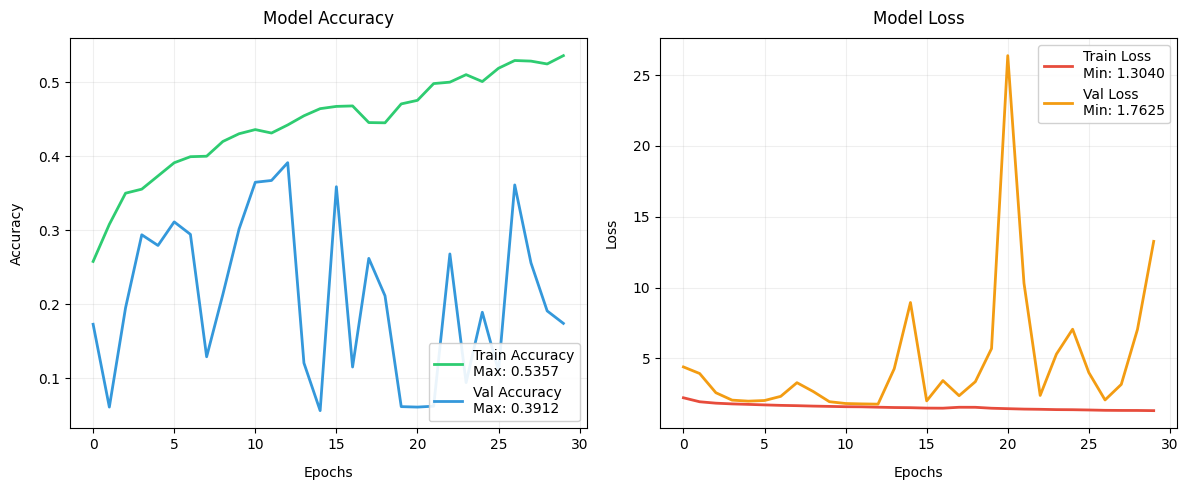

In [10]:


import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """Enhanced function to plot training history with accuracy and loss curves"""

    # Create figure with subplots
    plt.figure(figsize=(12, 5))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],
             label=f'Train Accuracy\nMax: {np.max(history.history["accuracy"]):.4f}',
             color='#2ecc71',  # Green
             linewidth=2)
    plt.plot(history.history['val_accuracy'],
             label=f'Val Accuracy\nMax: {np.max(history.history["val_accuracy"]):.4f}',
             color='#3498db',  # Blue
             linewidth=2)

    plt.title('Model Accuracy', pad=10)
    plt.xlabel('Epochs', labelpad=10)
    plt.ylabel('Accuracy', labelpad=10)
    plt.legend(loc='lower right', framealpha=0.9)
    plt.grid(alpha=0.2)

    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],
             label=f'Train Loss\nMin: {np.min(history.history["loss"]):.4f}',
             color='#e74c3c',  # Red
             linewidth=2)
    plt.plot(history.history['val_loss'],
             label=f'Val Loss\nMin: {np.min(history.history["val_loss"]):.4f}',
             color='#f39c12',  # Orange
             linewidth=2)

    plt.title('Model Loss', pad=10)
    plt.xlabel('Epochs', labelpad=10)
    plt.ylabel('Loss', labelpad=10)
    plt.legend(loc='upper right', framealpha=0.9)
    plt.grid(alpha=0.2)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Usage
plot_training_history(history)

Saving rosacea-steroid-8.jpg to rosacea-steroid-8.jpg
Processing image: rosacea-steroid-8.jpg


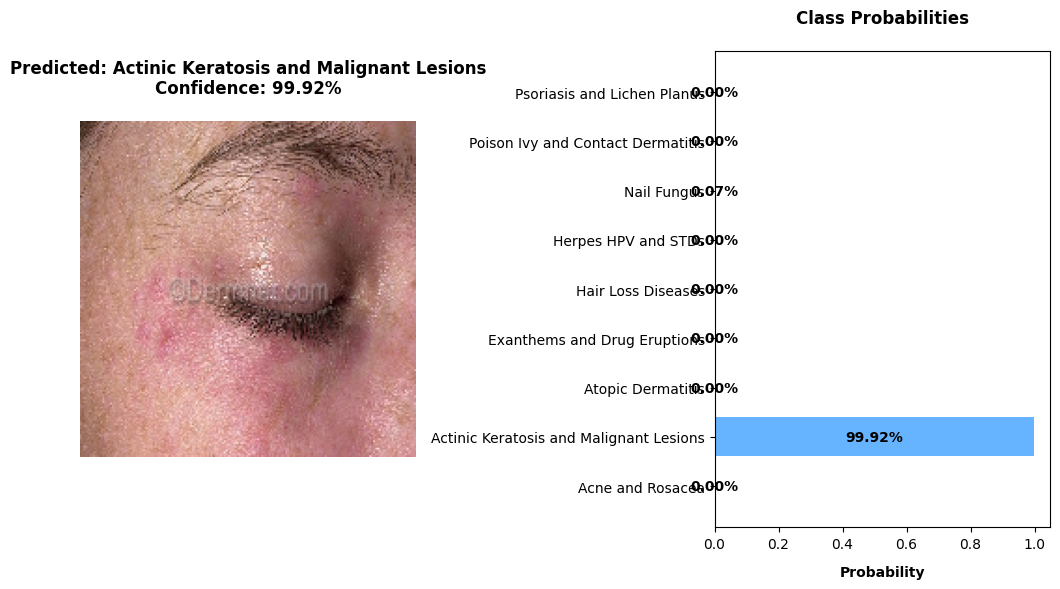


Final Prediction: Actinic Keratosis and Malignant Lesions (Confidence: 99.92%)


In [16]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Upload image from local machine
uploaded = files.upload()
image_name = next(iter(uploaded))
print(f"Processing image: {image_name}")

def predict_image(img_path, model, img_height=180, img_width=180):
    """
    Skin disease prediction function with visualization

    Args:
        img_path (str): Path to the image file
        model (keras.Model): Trained Keras model
        img_height (int): Model input height
        img_width (int): Model input width
    """
    # Class names mapping
    class_names = [
        'Acne and Rosacea',
        'Actinic Keratosis and Malignant Lesions',
        'Atopic Dermatitis',
        'Exanthems and Drug Eruptions',
        'Hair Loss Diseases',
        'Herpes HPV and STDs',
        'Nail Fungus',
        'Poison Ivy and Contact Dermatitis',
        'Psoriasis and Lichen Planus'
    ]

    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array, verbose=0)[0]
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions)

        # Create visualization
        plt.figure(figsize=(10, 6))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}",
                 fontweight='bold', pad=20)
        plt.axis('off')

        # Display prediction probabilities
        plt.subplot(1, 2, 2)
        colors = ['#ff9999' if i != np.argmax(predictions) else '#66b3ff'
                 for i in range(len(class_names))]
        bars = plt.barh(class_names, predictions, color=colors)

        # Add percentage labels
        for bar, prob in zip(bars, predictions):
            width = bar.get_width()
            plt.text(width/2, bar.get_y() + bar.get_height()/2,
                    f"{prob:.2%}",
                    ha='center', va='center',
                    fontweight='bold')

        plt.xlabel('Probability', fontweight='bold', labelpad=10)
        plt.title('Class Probabilities', fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        return predicted_class, confidence

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Make prediction on uploaded image
predicted_class, confidence = predict_image(image_name, model)
print(f"\nFinal Prediction: {predicted_class} (Confidence: {confidence:.2%})")

In [18]:
model.save('skin_disease_model.h5')  # Saves model architecture + weights

# Download the model file to your local machine
from google.colab import files
files.download('skin_disease_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>